
# **0. 준비**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 나눔 폰트 설치 / 한글 깨짐 방지 , 런타임 다시 시작하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,109 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and dire

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [2]:
# 시각화에 사용할 팔레트
plt.style.available

sns.color_palette("pastel")
sns.set(palette='pastel')


# **1. 데이터 구조 파악**

#### **(1) 데이터 불러오기**

[Feature variable] - 10개
* tm : 시간 (날짜 및 시각, 00시~23시)
* branch_id : 지사명 (비식별화 처리)
* ta : 기온 (정시 기온,°C)
* wd : 풍향 (정시 10분 평균 풍향, degree)
* ws : 풍속 (정시 10분 평균 풍속, m/s)
* rn_day : 일 강수량 (해당 시간까지의 일강수량, mm)
* rn_hr1 : 시간 강수량 (1시간 강수량, mm)
* hm : 상대 습도 (정시 상대 습도, %)
* si : 일사량 (ASOS 일사량, MJ/m^2)
* ta_chi : 체감온도 (500m 객관분석 자료,°C)

[Target Variable]
* heat_demand : 열수요 (시간당 지사별 열 공급량, Gcal/h)

In [9]:
# train data 불러오기
df_train = pd.read_csv("/content/drive/MyDrive/weather_bigcontest/data/train_heat.csv")
df_train = df_train.iloc[:,1:]
df_train

,train_heat.tm,train_heat.branch_id,train_heat.ta,train_heat.wd,train_heat.ws,train_heat.rn_day,train_heat.rn_hr1,train_heat.hm,train_heat.si,train_heat.ta_chi,train_heat.heat_demand
0,2021010101,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
1,2021010102,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262
2,2021010103,A,-10.0,360.0,0.0,0.0,0.0,69.2,-99.0,-8.8,266
3,2021010104,A,-9.3,155.9,0.5,0.0,0.0,65.0,-99.0,-8.9,285
4,2021010105,A,-9.0,74.3,1.9,0.0,0.0,63.5,-99.0,-9.2,283
...,...,...,...,...,...,...,...,...,...,...,...
499296,2023123119,S,3.2,233.5,0.4,2.5,0.0,91.5,-99.0,2.8,34
499297,2023123120,S,2.9,227.4,0.1,2.5,0.0,92.1,-99.0,2.7,35
499298,2023123121,S,2.1,360.0,0.0,2.5,0.0,93.3,-99.0,1.4,35
499299,2023123122,S,2.2,30.0,1.4,2.5,0.0,95.5,-99.0,1.3,40


#### **(2) 데이터 확인하기**

In [10]:
# 변수명 정리
df_train.columns = [col.replace("train_heat.", "") for col in df_train.columns]

In [11]:
# tm 변수 datetime 처리
df_train['tm'] = pd.to_datetime(df_train['tm'].astype(str), format='%Y%m%d%H')

In [12]:
df_train.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,-99.0,-8.8,266
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,-99.0,-8.9,285
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,-99.0,-9.2,283


In [13]:
df_train.shape # 12개의 열, 10999개의 행

(499301, 11)

In [14]:
df_train.describe()

,tm,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
count,499301,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000,499301.000000
mean,2022-07-02 12:00:00,10.621007,194.322872,-2.344705,-1.843207,-3.649492,53.024052,-45.600886,13.869692,95.861923
min,2021-01-01 01:00:00,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000
25%,2021-10-01 18:00:00,4.400000,105.000000,0.500000,0.000000,0.000000,44.900000,-99.000000,4.400000,25.000000
50%,2022-07-02 12:00:00,14.200000,212.100000,1.100000,0.000000,0.000000,64.700000,0.000000,15.000000,55.000000
75%,2023-04-02 06:00:00,22.500000,294.300000,2.000000,0.000000,0.000000,82.500000,0.960000,24.300000,116.000000
max,2023-12-31 23:00:00,37.800000,360.000000,11.900000,326.500000,92.500000,100.000000,3.920000,37.100000,966.000000
std,NaN,20.878917,118.348853,19.161911,21.340679,19.082926,49.080340,49.938291,11.888126,115.269280


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           499301 non-null  float64       
 3   wd           499301 non-null  float64       
 4   ws           499301 non-null  float64       
 5   rn_day       499301 non-null  float64       
 6   rn_hr1       499301 non-null  float64       
 7   hm           499301 non-null  float64       
 8   si           499301 non-null  float64       
 9   ta_chi       499301 non-null  float64       
 10  heat_demand  499301 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 41.9+ MB


> 결측치가 -99로 기록되어있어 null로 인식이 안 됨



In [16]:
# -99 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']


In [17]:
# -99.0을 np.nan으로 바꾸기
df_train[cols_with_neg99] = df_train[cols_with_neg99].replace(-99.0, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: []


In [18]:
# -9.9 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ta_chi']


>  wd는 -9.9도 null임



In [19]:
# -9.9를 np.nan으로 바꾸기
df_train['wd'] = df_train['wd'].replace(-9.9, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-9.9' 포함 열:", cols_with_neg99)

'-9.9' 포함 열: ['ta', 'ta_chi']


* 다시 데이터 확인

In [20]:
df_train.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,NaN,-8.2,281.0
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,NaN,-8.6,262.0
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,NaN,-8.8,266.0
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,NaN,-8.9,285.0
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,NaN,-9.2,283.0


In [21]:
df_train.shape

(499301, 11)

In [22]:
df_train.describe()

,tm,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
count,499301,486304.000000,478897.000000,480486.000000,480675.000000,480147.000000,459584.000000,266379.000000,499281.000000,499278.000000
mean,2022-07-02 12:00:00,13.550747,206.524619,1.440149,1.921587,0.154225,66.161889,1.091339,13.874214,95.870900
min,2021-01-01 01:00:00,-19.700000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,-24.700000,0.000000
25%,2021-10-01 18:00:00,5.200000,119.500000,0.500000,0.000000,0.000000,50.300000,0.210000,4.400000,25.000000
50%,2022-07-02 12:00:00,14.700000,221.600000,1.200000,0.000000,0.000000,67.600000,0.850000,15.000000,55.000000
75%,2023-04-02 06:00:00,22.700000,297.400000,2.100000,0.000000,0.000000,84.000000,1.820000,24.300000,116.000000
max,2023-12-31 23:00:00,37.800000,360.000000,11.900000,326.500000,92.500000,100.000000,3.920000,37.100000,966.000000
std,NaN,10.855174,104.573652,1.185264,9.649994,1.236777,21.146626,0.972380,11.866881,115.264347


In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           486304 non-null  float64       
 3   wd           478897 non-null  float64       
 4   ws           480486 non-null  float64       
 5   rn_day       480675 non-null  float64       
 6   rn_hr1       480147 non-null  float64       
 7   hm           459584 non-null  float64       
 8   si           266379 non-null  float64       
 9   ta_chi       499281 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


In [24]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

             Missing Count  Missing Ratio (%)
si                  232922          46.649616
hm                   39717           7.954520
wd                   20404           4.086513
rn_hr1               19154           3.836163
ws                   18815           3.768268
rn_day               18626           3.730415
ta                   12997           2.603039
heat_demand             23           0.004606
ta_chi                  20           0.004006


* 시간 관련 변수 생성 (우선 EDA 및 분석을 위해서)

In [25]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [28]:
df_train['hour'] = df_train['tm'].dt.hour
df_train['year'] = df_train['tm'].dt.year # 연도
df_train['quarter'] = df_train['tm'].dt.quarter # 분기별
df_train['month'] = df_train['tm'].dt.month # 월
df_train['day_of_week'] = df_train['tm'].dt.dayofweek # 요일
df_train['season'] = df_train['month'].apply(get_season) # 계절
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday') # 주말 여부
df_train['weekofyear'] = df_train['tm'].dt.isocalendar().week # 주차

# 3시간 단위 시간대 컬럼 생성 (0~23시 → 0~7로 구간화)
df_train['hour_group'] = (df_train['tm'].dt.hour // 3).astype(int)
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

In [29]:
df_train.head()

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand,year,quarter,month,day_of_week,season,is_weekend,weekofyear,hour_group,hour
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,NaN,-8.2,281.0,2021,1,1,4,Winter,Weekday,53,0,1
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,NaN,-8.6,262.0,2021,1,1,4,Winter,Weekday,53,0,2
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,NaN,-8.8,266.0,2021,1,1,4,Winter,Weekday,53,1,3
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,NaN,-8.9,285.0,2021,1,1,4,Winter,Weekday,53,1,4
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,NaN,-9.2,283.0,2021,1,1,4,Winter,Weekday,53,1,5


* 일사량 결측 처리

 이걸 채우고 돌리는 게 맞는지 고민하다가, 어차피 뒤에서 중앙값을 구할거고 / 다른 결측치를 건드리지 않을거라면 이것도 그대로 두는 게 맞는 것 같아서 안 함

# **2. Clustering**

처음 제안했던 방식들 중에서
열수요만 고려 + 표준화 X + 클러스터 개수 4개 채택

**[접근 방식 요약]**

목표 : branch_id별 열수요의 시간대별 패턴을 바탕으로 지점 유형 군집화를 수행

* branch_id별로 열수요의 1시간 단위/3시간 단위/월별/계절별 중앙값 패턴 추출
* 즉, 시간에 따른 열수요 패턴의 유사성을 중심으로 군집화

**[과정]**

1. 중앙값 패턴 추출
    * 그룹 기준 : branch_id x 시간 변수(hour, hour_group, month, season)
    * 대상 변수 : 열수요 (heat_demand)
    * 방법: .groupby().median().pivot()을 활용한 wide-format 생성

2. wide-format 데이터프레임 구성
    * branch_id를 index로,시간/계절/월 단위의 패턴을 열(columns)로 구성
    * → ex) hour0, hour1, ..., month1, ..., season_Winter

3. 표준화 여부

  행 단위 변수별 표준화를 진행하지 않음
    * 절대적인 열수요의 양과 차이를 반영하기 위해서 표준화를 진행하지 않음
    * 예를 들어, A건물 (100, 150,200) B건물 (20,30,40)일 때, 절대량을 고려하기 때문에 고수요/저수요로 나뉘게 됨

4. 시각화
    *-> 시각화를 통해 각 브랜치가 경향을 가지는지 확인*



##### **(1) 중앙값 패턴 추출**

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499301 entries, 0 to 499300
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499301 non-null  datetime64[ns]
 1   branch_id    499301 non-null  object        
 2   ta           486304 non-null  float64       
 3   wd           478897 non-null  float64       
 4   ws           480486 non-null  float64       
 5   rn_day       480675 non-null  float64       
 6   rn_hr1       480147 non-null  float64       
 7   hm           459584 non-null  float64       
 8   si           266379 non-null  float64       
 9   ta_chi       499281 non-null  float64       
 10  heat_demand  499278 non-null  float64       
 11  year         499301 non-null  int32         
 12  quarter      499301 non-null  int32         
 13  month        499301 non-null  int32         
 14  day_of_week  499301 non-null  int32         
 15  season       499301 non-null  obje

In [31]:
# 시간 단위별 중앙값 (1시간 단위)
by_hour = df_train.groupby(['branch_id', 'hour'])['heat_demand'].median().reset_index()
by_hour = by_hour.pivot(index='branch_id', columns='hour', values='heat_demand').reset_index()
by_hour.columns = ['branch_id'] + [f'hour{h}' for h in range(24)]

# 3시간 단위
by_hour3 = df_train.groupby(['branch_id', 'hour_group'])['heat_demand'].median().reset_index()
by_hour3 = by_hour3.pivot(index='branch_id', columns='hour_group', values='heat_demand').reset_index()
by_hour3.columns = ['branch_id'] + [f'hour3_{h}' for h in sorted(df_train['hour_group'].unique())]

# 월 단위
by_month = df_train.groupby(['branch_id', 'month'])['heat_demand'].median().reset_index()
by_month = by_month.pivot(index='branch_id', columns='month', values='heat_demand').reset_index()
by_month.columns = ['branch_id'] + [f'month{m}' for m in range(1,13)]

# 계절 단위
by_season = df_train.groupby(['branch_id', 'season'])['heat_demand'].median().reset_index()
by_season = by_season.pivot(index='branch_id', columns='season', values='heat_demand').reset_index()
by_season.columns = ['branch_id'] + [f'season_{s}' for s in df_train['season'].unique()]

In [32]:
# 모든 시간 기준 패턴 데이터 병합
df_pattern = by_hour.merge(by_hour3, on='branch_id') \
                    .merge(by_month, on='branch_id') \
                    .merge(by_season, on='branch_id')

In [33]:
df_pattern

,branch_id,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,...,month7,month8,month9,month10,month11,month12,season_Winter,season_Spring,season_Summer,season_Autumn
0,A,75.0,67.0,63.0,60.0,61.0,68.0,73.0,73.0,75.0,...,29.0,26.0,29.0,54.0,124.0,231.0,51.0,72.0,29.0,239.0
1,B,189.0,164.0,143.0,127.0,123.0,124.0,133.0,157.0,179.0,...,69.0,61.0,67.0,121.0,258.0,480.0,116.0,172.0,68.0,486.0
2,C,205.5,178.0,169.0,161.0,155.0,157.0,161.0,180.0,190.0,...,90.0,87.0,88.0,132.5,287.0,518.0,130.0,171.0,91.0,526.0
3,D,114.0,103.0,95.0,91.0,90.0,92.0,101.0,117.0,130.0,...,52.0,42.0,46.0,91.0,182.0,331.0,88.0,115.0,49.0,338.0
4,E,31.0,26.0,23.0,22.0,21.0,22.0,27.0,42.0,62.0,...,39.0,39.0,26.0,26.0,46.0,98.0,32.0,34.0,35.0,98.0
5,F,50.0,45.0,39.0,36.0,34.0,34.0,36.0,46.0,53.0,...,51.0,45.0,36.0,38.0,68.0,123.0,44.0,48.0,43.0,126.0
6,G,169.0,149.0,140.0,132.0,129.0,127.0,129.0,142.0,163.0,...,69.0,60.0,70.0,116.0,233.0,422.0,111.0,153.5,69.0,429.0
7,H,109.5,88.0,77.0,73.0,74.0,76.0,84.0,95.0,105.0,...,33.0,30.0,39.0,73.0,156.5,290.0,71.0,98.0,35.0,293.0
8,I,56.0,45.0,42.0,40.0,39.0,38.0,41.0,52.0,62.0,...,40.0,36.0,32.0,38.0,81.0,156.0,43.0,54.0,37.0,157.0
9,J,60.0,49.0,42.0,39.0,38.0,38.0,40.0,49.0,61.0,...,56.5,59.0,49.0,49.0,83.0,156.0,57.0,61.0,54.0,158.0


In [35]:
df_pattern.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   branch_id      19 non-null     object 
 1   hour0          19 non-null     float64
 2   hour1          19 non-null     float64
 3   hour2          19 non-null     float64
 4   hour3          19 non-null     float64
 5   hour4          19 non-null     float64
 6   hour5          19 non-null     float64
 7   hour6          19 non-null     float64
 8   hour7          19 non-null     float64
 9   hour8          19 non-null     float64
 10  hour9          19 non-null     float64
 11  hour10         19 non-null     float64
 12  hour11         19 non-null     float64
 13  hour12         19 non-null     float64
 14  hour13         19 non-null     float64
 15  hour14         19 non-null     float64
 16  hour15         19 non-null     float64
 17  hour16         19 non-null     float64
 18  hour17      

In [36]:
df_pattern.columns

Index(['branch_id', 'hour0', 'hour1', 'hour2', 'hour3', 'hour4', 'hour5',
       'hour6', 'hour7', 'hour8', 'hour9', 'hour10', 'hour11', 'hour12',
       'hour13', 'hour14', 'hour15', 'hour16', 'hour17', 'hour18', 'hour19',
       'hour20', 'hour21', 'hour22', 'hour23', 'hour3_0', 'hour3_1', 'hour3_2',
       'hour3_3', 'hour3_4', 'hour3_5', 'hour3_6', 'hour3_7', 'month1',
       'month2', 'month3', 'month4', 'month5', 'month6', 'month7', 'month8',
       'month9', 'month10', 'month11', 'month12', 'season_Winter',
       'season_Spring', 'season_Summer', 'season_Autumn'],
      dtype='object')

* 그래프로 확인

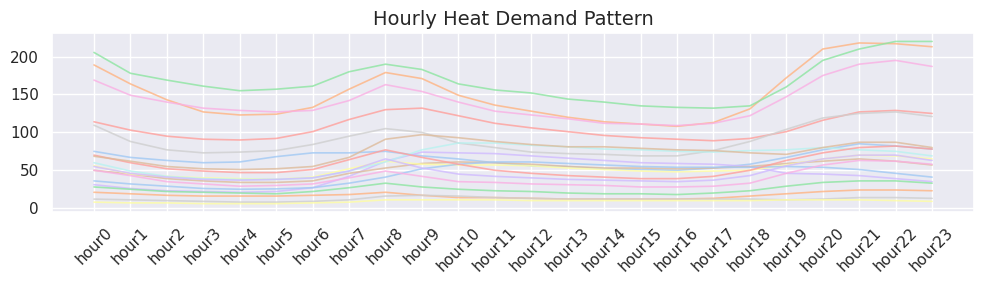

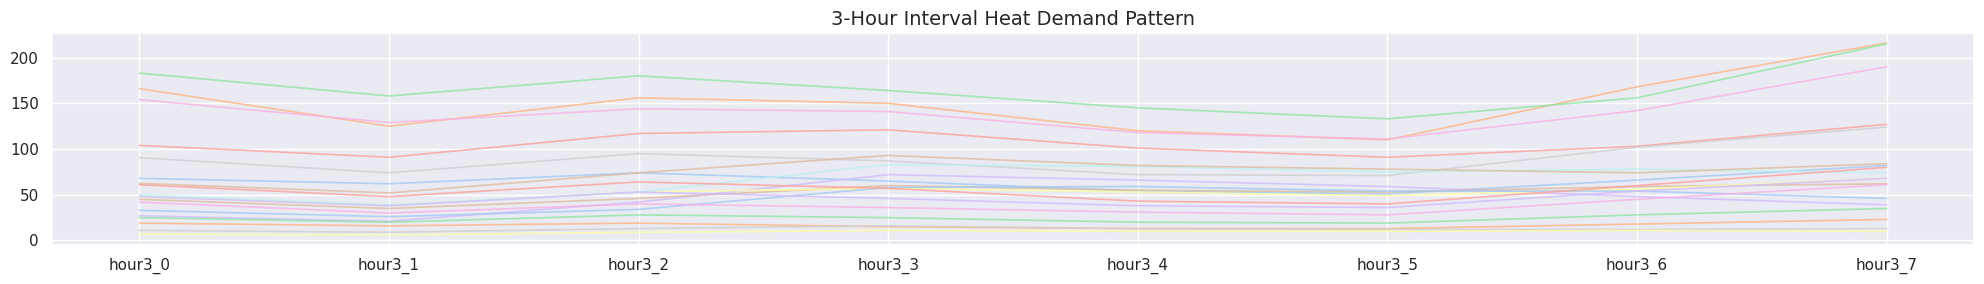

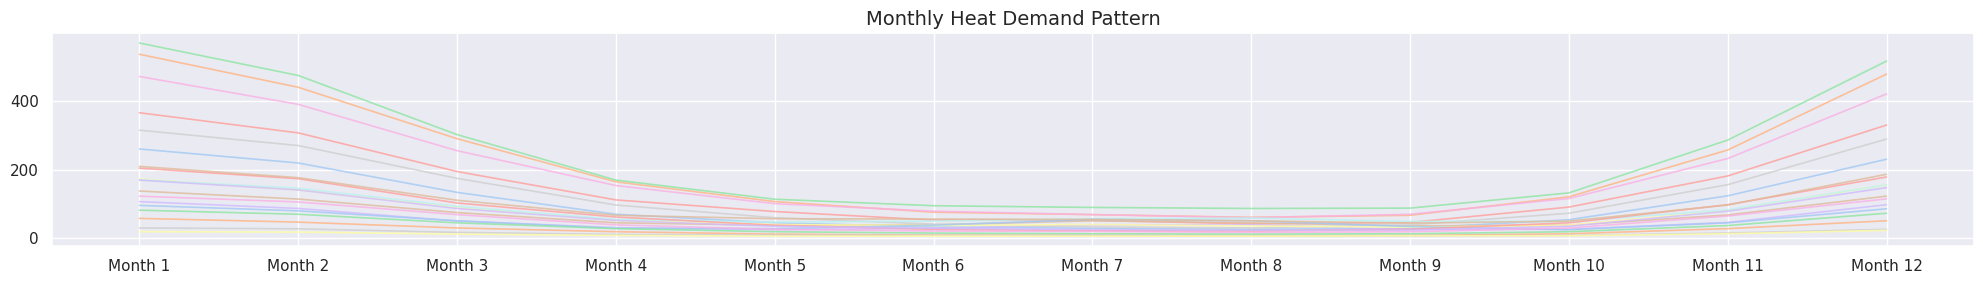

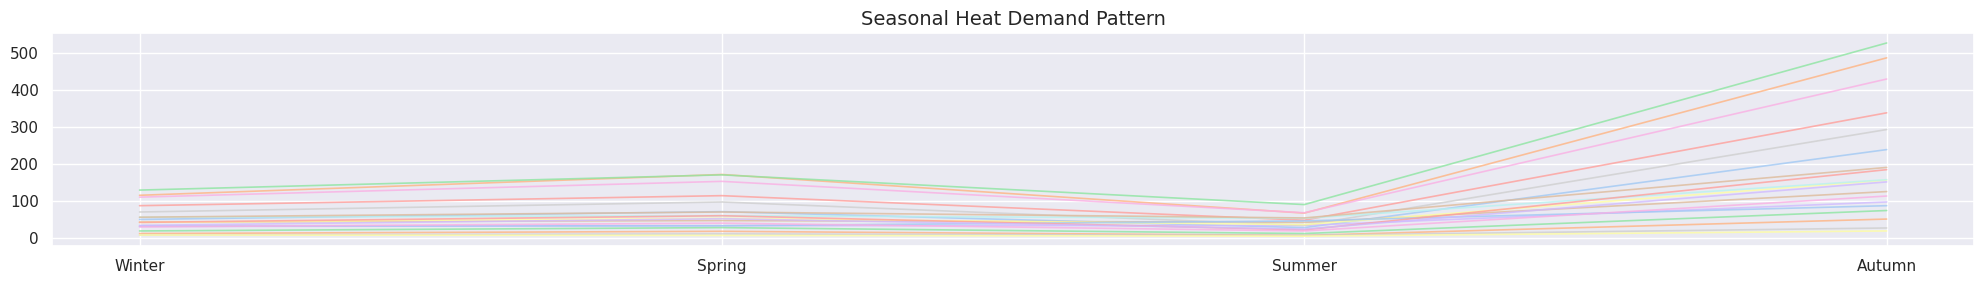

In [37]:
# 1시간 단위 시각화 (hour0 ~ hour23)
fig = plt.figure(figsize=(10, 3))
for i in range(len(df_pattern)):
    plt.plot(df_pattern.iloc[i, 1:25], alpha=0.8, linewidth=1.2)
plt.title("Hourly Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(24), labels=[f'hour{i}' for i in range(24)], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3시간 단위 시각화 (hour3_0 ~ hour3_7)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern)):
    plt.plot(df_pattern.iloc[i, 25:33], alpha=0.8, linewidth=1.2)
plt.title("3-Hour Interval Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(8), labels=[f'hour3_{i}' for i in range(8)], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 월별 시각화 (month1 ~ month12 assumed at 33:44)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern)):
    plt.plot(df_pattern.iloc[i, 33:45], alpha=0.8, linewidth=1.2)
plt.title("Monthly Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(12), labels=[f'Month {i+1}' for i in range(12)], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# 계절별 시각화 (season_Winter ~ season_Autumn assumed at 45:49)
fig = plt.figure(figsize=(20, 3))
for i in range(len(df_pattern)):
    plt.plot(df_pattern.iloc[i, 45:49], alpha=0.8, linewidth=1.2)
plt.title("Seasonal Heat Demand Pattern", fontsize=14)
plt.xticks(ticks=range(4), labels=["Winter", "Spring", "Summer", "Autumn"])
plt.grid(True)
plt.tight_layout()
plt.show()

=> branch_id 별로 다 다른 경향을 가지는 것으로 보임. 이 데이터프레임을 사용해서 군집화를 진행해도 되겠다!

##### **(2) 최적의 k 개수 선정**

In [38]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

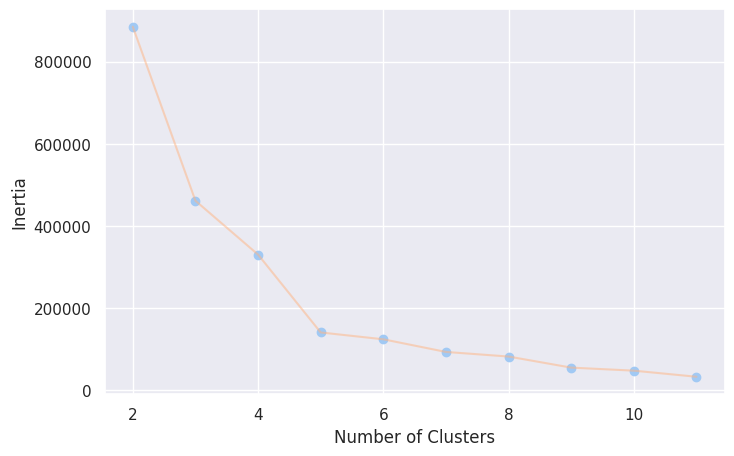

In [39]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df_pattern.iloc[:,1:])

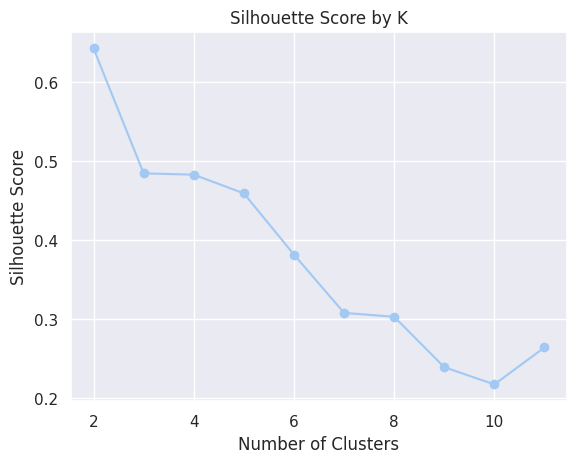

In [40]:
scores = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_pattern.iloc[:,1:])
    score = silhouette_score(df_pattern.iloc[:,1:], labels)
    scores.append(score)

# 시각화
plt.plot(range(2, 12), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K')
plt.grid(True)
plt.show()

##### **(3) KMeans 군집화 수행**

In [41]:
kmeans4 = KMeans(n_clusters=4, random_state = 0)
km_cluster4 = kmeans4.fit_predict(df_pattern.iloc[:,1:])

In [43]:
# cluster 열을 추가한 데이터프레임 생성
df_clust_num4 = df_pattern.copy()
df_clust_num4['km_cluster'] = km_cluster4

In [44]:
df_clust_num4

,branch_id,hour0,hour1,hour2,hour3,hour4,hour5,hour6,hour7,hour8,...,month8,month9,month10,month11,month12,season_Winter,season_Spring,season_Summer,season_Autumn,km_cluster
0,A,75.0,67.0,63.0,60.0,61.0,68.0,73.0,73.0,75.0,...,26.0,29.0,54.0,124.0,231.0,51.0,72.0,29.0,239.0,2
1,B,189.0,164.0,143.0,127.0,123.0,124.0,133.0,157.0,179.0,...,61.0,67.0,121.0,258.0,480.0,116.0,172.0,68.0,486.0,1
2,C,205.5,178.0,169.0,161.0,155.0,157.0,161.0,180.0,190.0,...,87.0,88.0,132.5,287.0,518.0,130.0,171.0,91.0,526.0,1
3,D,114.0,103.0,95.0,91.0,90.0,92.0,101.0,117.0,130.0,...,42.0,46.0,91.0,182.0,331.0,88.0,115.0,49.0,338.0,2
4,E,31.0,26.0,23.0,22.0,21.0,22.0,27.0,42.0,62.0,...,39.0,26.0,26.0,46.0,98.0,32.0,34.0,35.0,98.0,0
5,F,50.0,45.0,39.0,36.0,34.0,34.0,36.0,46.0,53.0,...,45.0,36.0,38.0,68.0,123.0,44.0,48.0,43.0,126.0,0
6,G,169.0,149.0,140.0,132.0,129.0,127.0,129.0,142.0,163.0,...,60.0,70.0,116.0,233.0,422.0,111.0,153.5,69.0,429.0,1
7,H,109.5,88.0,77.0,73.0,74.0,76.0,84.0,95.0,105.0,...,30.0,39.0,73.0,156.5,290.0,71.0,98.0,35.0,293.0,2
8,I,56.0,45.0,42.0,40.0,39.0,38.0,41.0,52.0,62.0,...,36.0,32.0,38.0,81.0,156.0,43.0,54.0,37.0,157.0,0
9,J,60.0,49.0,42.0,39.0,38.0,38.0,40.0,49.0,61.0,...,59.0,49.0,49.0,83.0,156.0,57.0,61.0,54.0,158.0,0


In [45]:
# 클러스터별 포함 지점 리스트
for c in sorted(df_clust_num4.km_cluster.unique()):
    members = df_clust_num4[df_clust_num4.km_cluster == c]['branch_id'].tolist()
    print(f'Cluster {c}: {members}')

Cluster 0: ['E', 'F', 'I', 'J', 'K', 'N', 'O', 'Q']
Cluster 1: ['B', 'C', 'G']
Cluster 2: ['A', 'D', 'H', 'P']
Cluster 3: ['L', 'M', 'R', 'S']


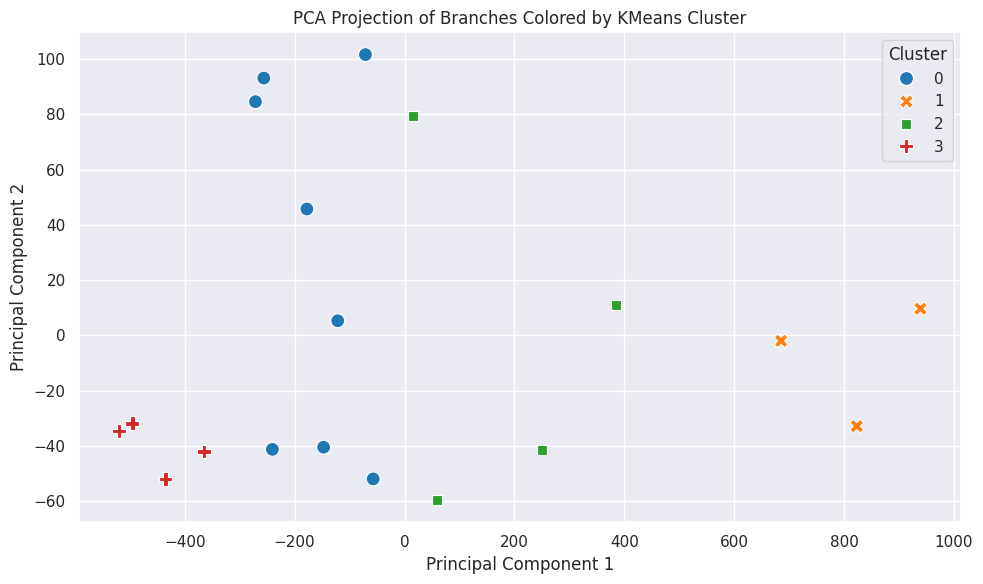

In [46]:
# branch_id와 cluster 제외한 feature만 사용
X = df_pattern.iloc[:, 1:]

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 결과 DataFrame 생성
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = km_cluster4  # 위에서 예측한 결과 사용
pca_df['branch_id'] = df_pattern['branch_id'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', style='cluster', palette='tab10', s=100)
plt.title("PCA Projection of Branches Colored by KMeans Cluster")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


##### **(4) 시각화**

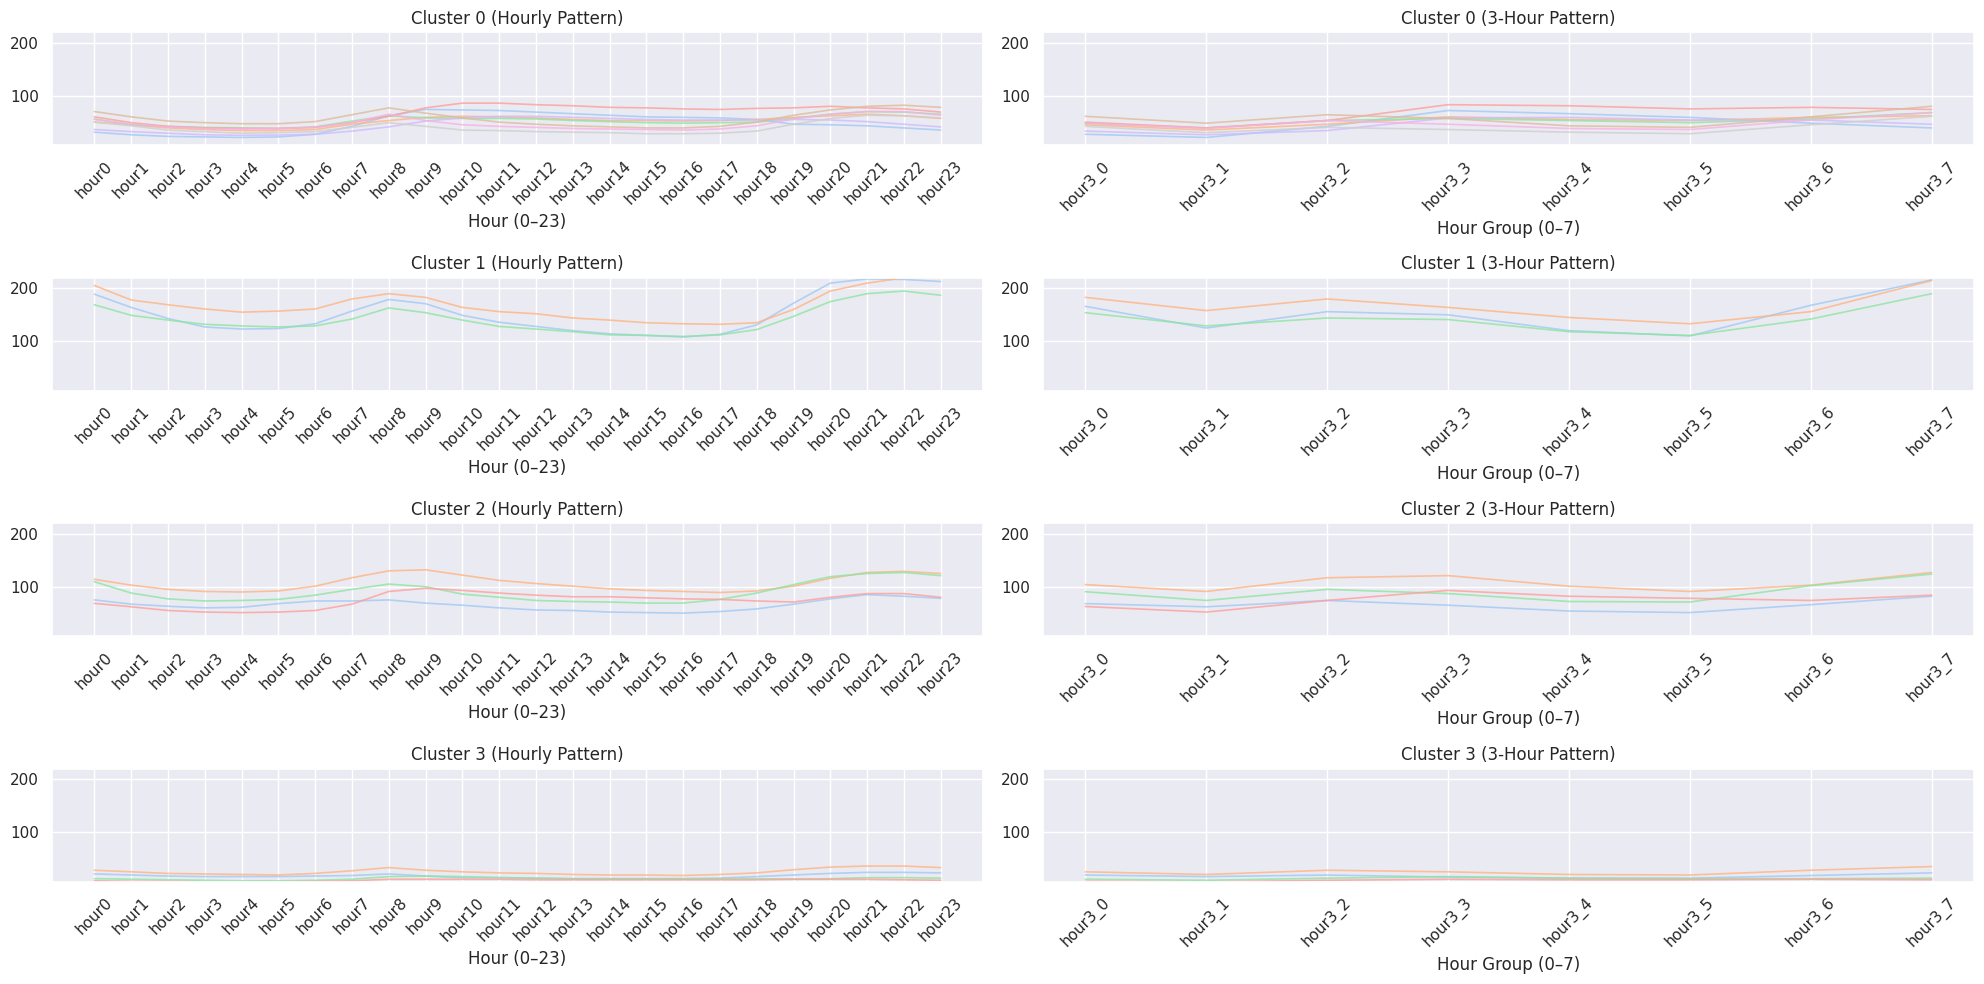

In [47]:
# 공통 y축 범위 계산
ymin = df_clust_num4.iloc[:, 1:33].min().min()
ymax = df_clust_num4.iloc[:, 1:33].max().max()
common_ylim = (ymin, ymax)

# 클러스터 수 자동 계산
n_c = len(np.unique(df_clust_num4.km_cluster))

# 시각화
fig = plt.figure(figsize=(20, 2.5 * n_c))

for c in range(n_c):
    temp = df_clust_num4[df_clust_num4.km_cluster == c]

    # 1시간 단위
    plt.subplot(n_c, 2, 2 * c + 1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 1:25], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Hourly Pattern)', fontsize=12)
    plt.xlabel('Hour (0–23)')
    plt.xticks(rotation=45)
    plt.ylim(common_ylim)
    plt.grid(True)

    # 3시간 단위
    plt.subplot(n_c, 2, 2 * c + 2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, 25:33], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (3-Hour Pattern)', fontsize=12)
    plt.xlabel('Hour Group (0–7)')
    plt.xticks(rotation=45)
    plt.ylim(common_ylim)
    plt.grid(True)

plt.tight_layout()
plt.show()

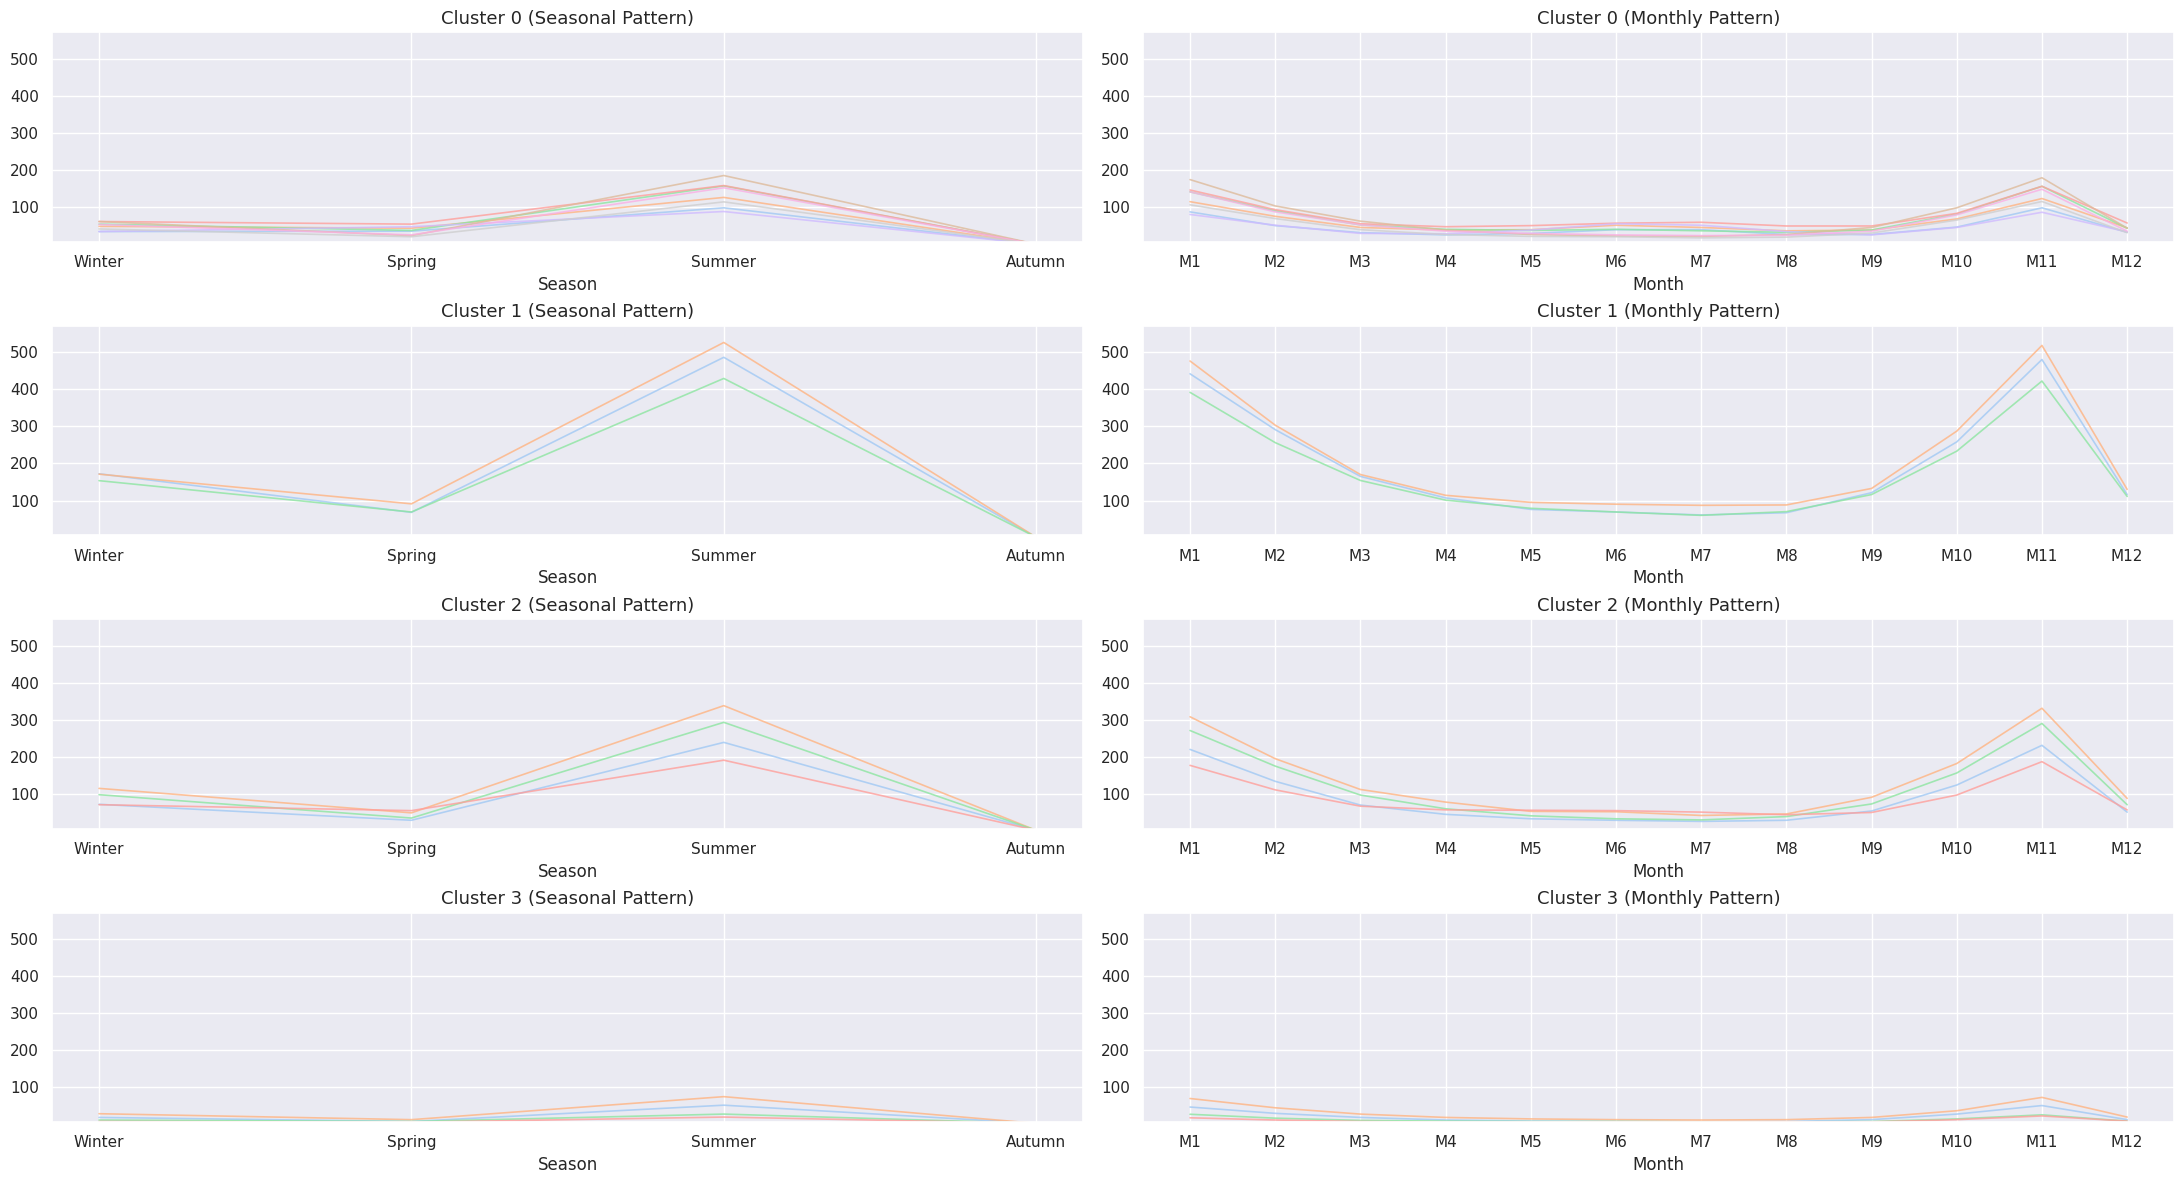

In [48]:
# 공통 y축 범위 계산 (열 수요 원본 기준)
ymin = df_clust_num4.iloc[:, 33:49].min().min()
ymax = df_clust_num4.iloc[:, 33:49].max().max()
common_ylim = (ymin, ymax)

# 클러스터 수 자동 계산
n_c = len(np.unique(df_clust_num4.km_cluster))

# 더 큰 그림 크기 확보
fig = plt.figure(figsize=(22, 3 * n_c))

for c in range(n_c):
    temp = df_clust_num4[df_clust_num4.km_cluster == c]

    # 계절별 시각화
    plt.subplot(n_c, 2, 2 * c + 1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, -4:], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Seasonal Pattern)', fontsize=13)
    plt.xticks(ticks=range(4), labels=['Winter', 'Spring', 'Summer', 'Autumn'])
    plt.xlabel('Season')
    plt.ylim(common_ylim)
    plt.grid(True)

    # 월별 시각화
    plt.subplot(n_c, 2, 2 * c + 2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i, -16:-4], alpha=0.8, linewidth=1.2)
    plt.title(f'Cluster {c} (Monthly Pattern)', fontsize=13)
    plt.xticks(ticks=range(12), labels=[f'M{i+1}' for i in range(12)])
    plt.xlabel('Month')
    plt.ylim(common_ylim)
    plt.grid(True)

# 여백 조정으로 잘림 방지
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # 수직 간격 조정
plt.show()

* 시도표

In [60]:
def plot_heat_demand_by_cluster(heat, cluster_list, cluster_name):
    # 클러스터 컬럼 생성
    heat['cluster'] = np.where(
        heat['branch_id'].isin(cluster_list), cluster_name, 'Other'
    )

    # 날짜 컬럼 생성 (날짜만 추출)
    heat['date'] = heat['tm'].dt.date

    # 일별 평균 heat_demand 계산
    heat_daily_avg = heat.groupby(['cluster', 'branch_id', 'date'])['heat_demand'].mean().reset_index()

    # 클러스터 데이터 필터링
    cluster_data = heat_daily_avg[heat_daily_avg['cluster'] == cluster_name]

    # 진한 색상 리스트 (기본 matplotlib 'tab10' 팔레트 사용)
    color_list = plt.get_cmap('tab10').colors
    color_cycle = iter(color_list)

    # 플롯 그리기
    plt.figure(figsize=(14, 8))
    for branch in cluster_data['branch_id'].unique():
        branch_data = cluster_data[cluster_data['branch_id'] == branch]
        color = next(color_cycle, 'black')  # 색상 리스트 반복
        plt.plot(branch_data['date'], branch_data['heat_demand'], label=f'{cluster_name} - {branch}', color=color)

    plt.title(f'Heat Demand Daily Average Trend for {cluster_name}')
    plt.xlabel('Date')
    plt.ylabel('Daily Average Heat Demand')
    plt.ylim(0, 800)  # Y축 범위 설정
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    plt.show()

In [61]:
def silhouette_score_for_heat_dynamic(heat, clusters_dict):
    import pandas as pd
    from sklearn.metrics import silhouette_score

    # branch별 heat_demand 통계 feature 생성
    features = heat.groupby('branch_id')['heat_demand'].agg(['mean', 'std', 'max', 'min']).reset_index()

    # clusters_dict는 { 'Cluster 0': [...], 'Cluster 1': [...], ... } 형태
    # branch_id에 맞게 클러스터 라벨 붙이기
    cluster_map = {}
    for cluster_name, branch_list in clusters_dict.items():
        for bid in branch_list:
            cluster_map[bid] = cluster_name

    features['cluster'] = features['branch_id'].map(cluster_map)

    # cluster 컬럼을 숫자 코드로 변환
    cluster_codes = features['cluster'].astype('category').cat.codes

    # feature 컬럼들
    feature_cols = ['mean', 'std', 'max', 'min']

    score = silhouette_score(features[feature_cols], cluster_codes)
    print(f'Silhouette Score: {score:.3f}')
    return score

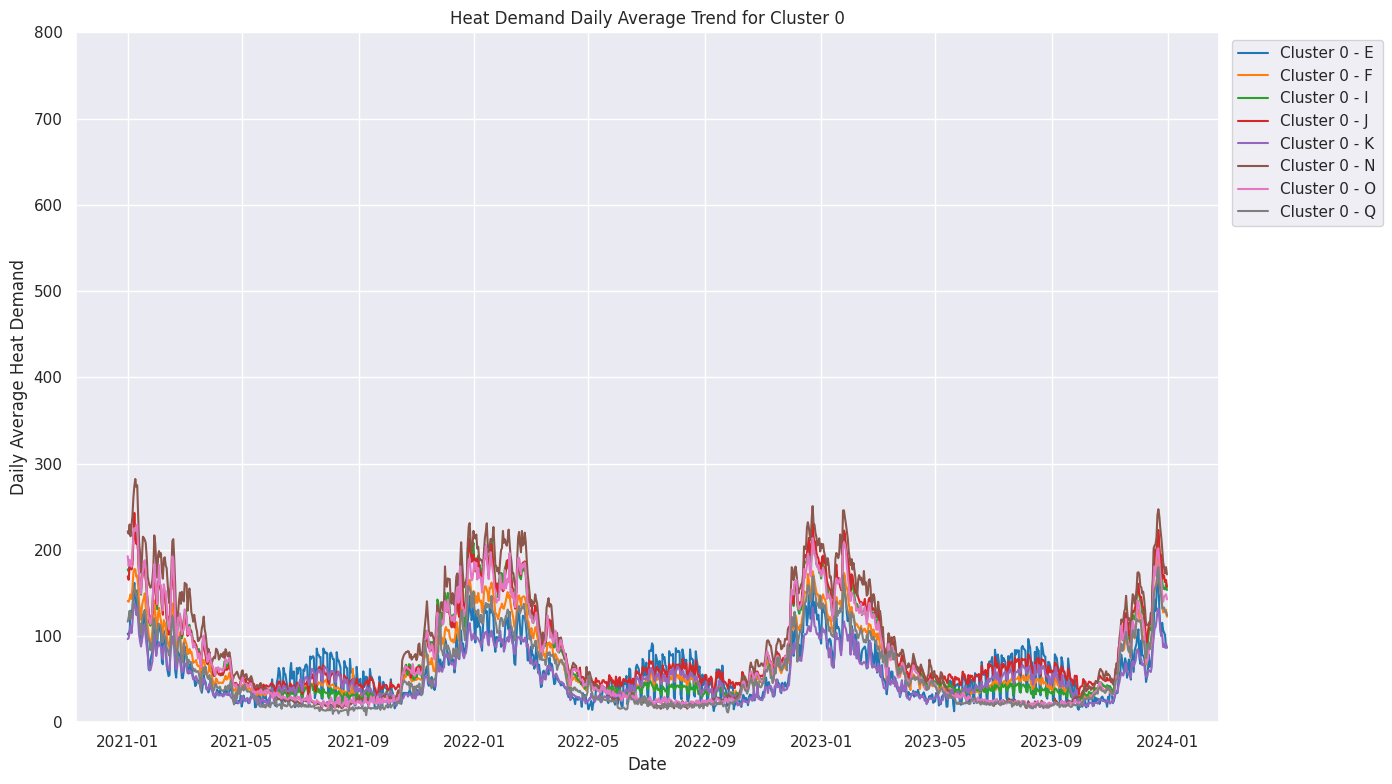

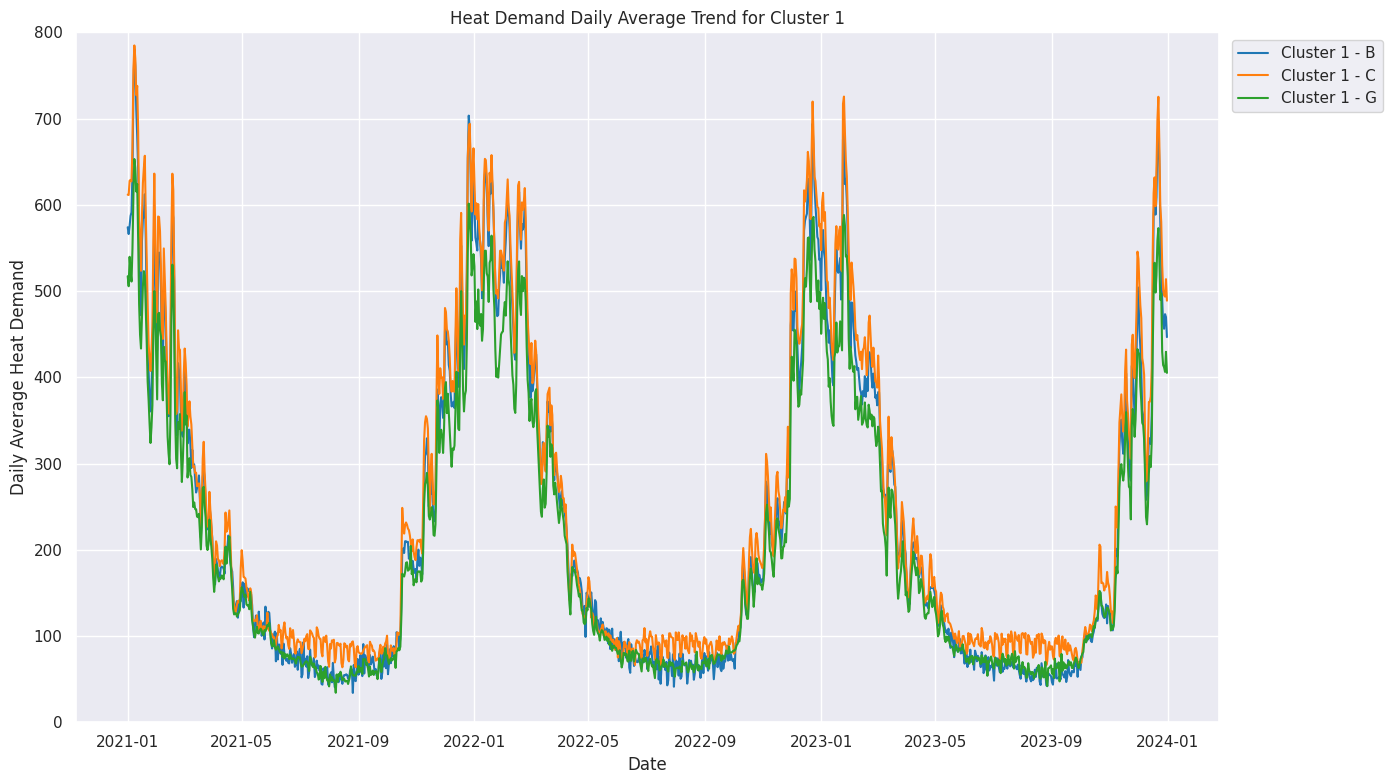

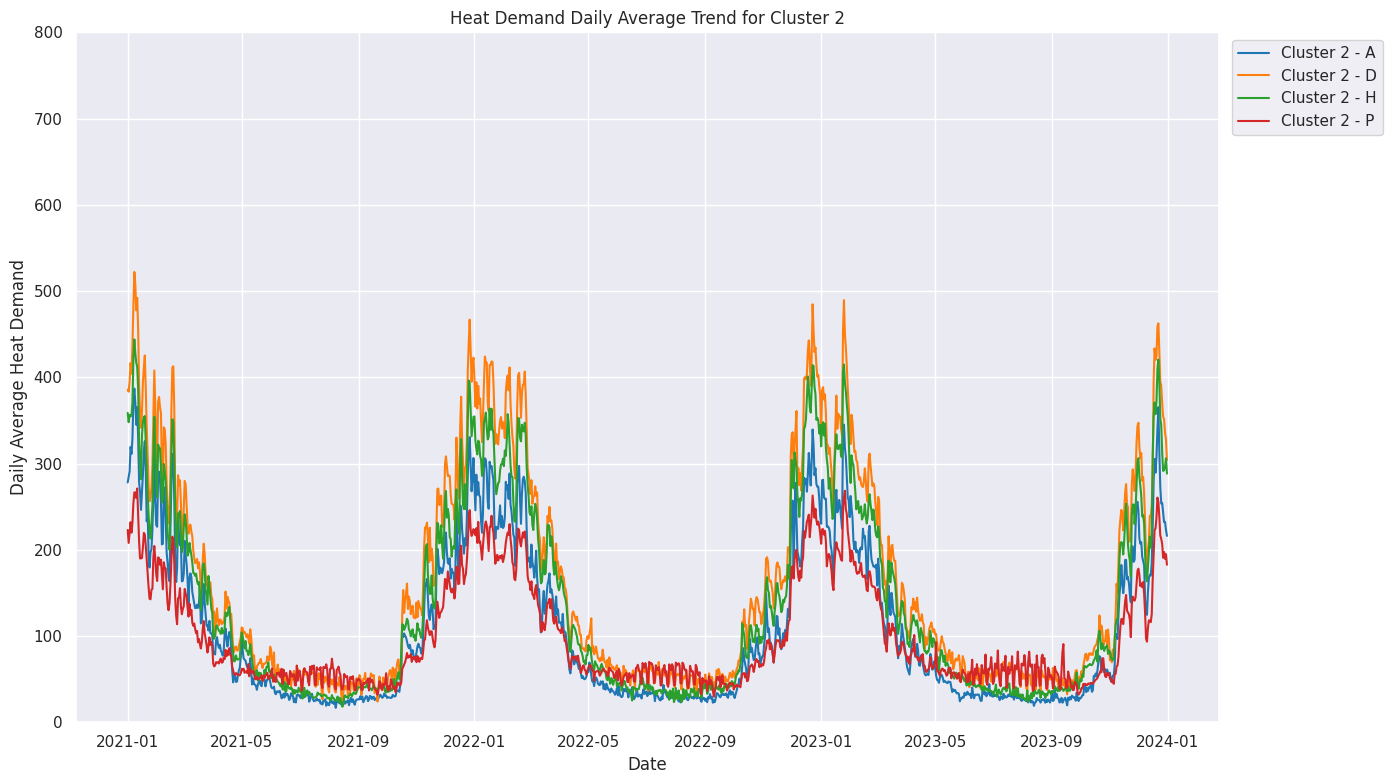

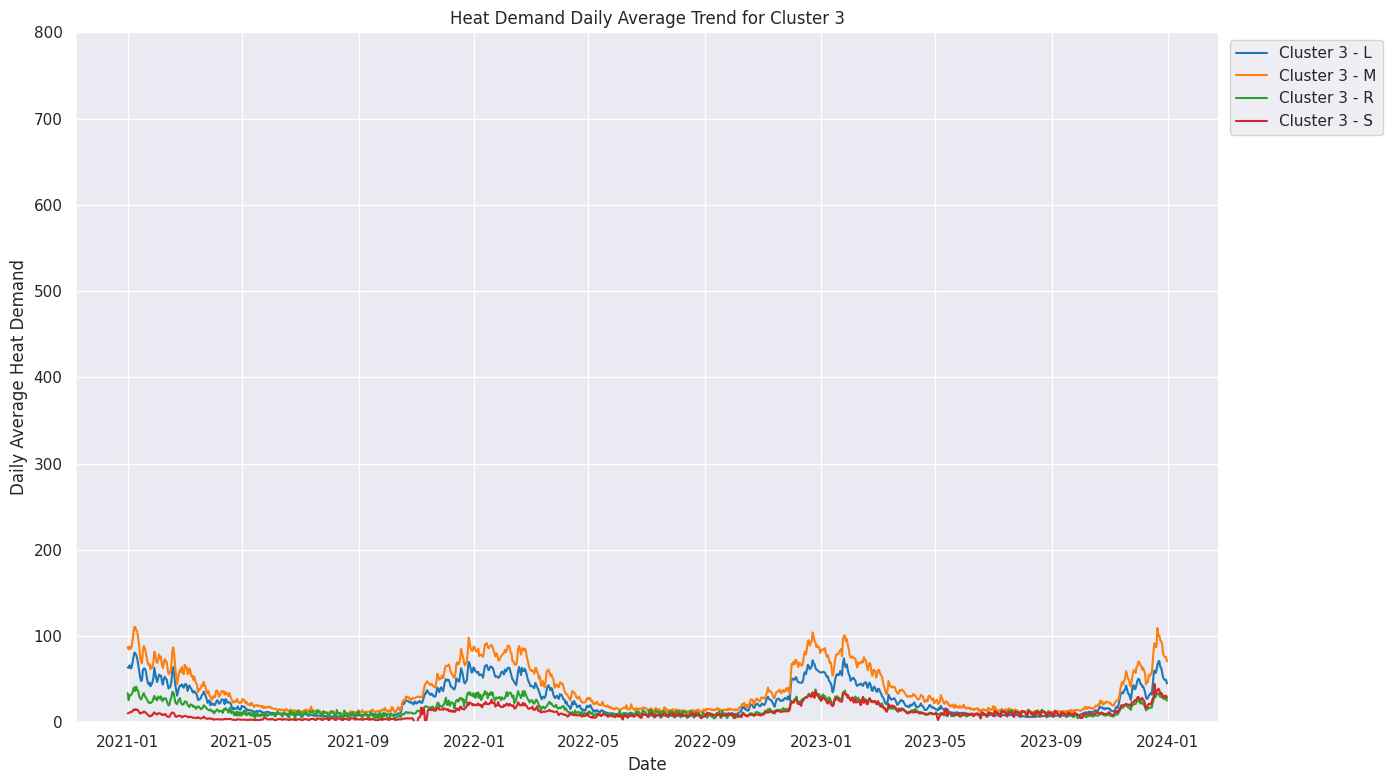

Silhouette Score: 0.448


In [62]:
# 혜현- 열수요만 고려 + 정규화 X + 클러스터 개수 =4
cluster_0 = ['E', 'F', 'I', 'J', 'K', 'N', 'O', 'Q']
cluster_1 = ['B', 'C', 'G']
cluster_2 = ['A', 'D', 'H', 'P']
cluster_3 = ['L', 'M', 'R', 'S']

plot_heat_demand_by_cluster(df_train, cluster_0, 'Cluster 0')
plot_heat_demand_by_cluster(df_train, cluster_1, 'Cluster 1')
plot_heat_demand_by_cluster(df_train, cluster_2, 'Cluster 2')
plot_heat_demand_by_cluster(df_train, cluster_3, 'Cluster 3')

clusters_dict = {
    'Cluster 2': cluster_2,
    'Cluster 0': cluster_0,
    'Cluster 1': cluster_1,
    'Cluster 3': cluster_3
}
silhouette_score_value = silhouette_score_for_heat_dynamic(df_train, clusters_dict)